In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [37]:
from fastai import *
from fastai.vision import *
from fastai.basic_data import *
# from fastai.callbacks import *
import os
import sys
import argparse
from copy import copy
import cv2
import imageio
from tqdm import tqdm_notebook as tqdm

In [ ]:
# This code is needed to properly load the model to make it ready for predictions
# You may have to make changes in these variables depending on where the model is:
#     PATH
#     IMAGES
#     MASKS
#     get_mask_name
#     m.load('change model name')


PATH = Path('/home/akash/Roads/spacenet/FINAL_DATA')

IMAGES = PATH/'images'
# MASKS = PATH/'masks'
MASKS = PATH/'masks_1'

def get_mask_name(im):
    if 'mass' in im.name:
        return str((MASKS/(im.stem + '.png')).absolute())
    root = im.name.split('_')[-1].split('.')[0]
    city = im.name.split('_')[-2]
    return str((MASKS/(city + 'mask_' + root + '.png')).absolute())

im_names = np.array(['images/'+o.name for o in IMAGES.ls()])
mask_names = np.array([get_mask_name(o) for o in IMAGES.ls()])

len(mask_names), len(im_names), len(list(IMAGES.iterdir()))

df = pd.DataFrame({'images':im_names, 'masks': mask_names})
tfms = get_transforms(flip_vert=True, max_rotate=90, max_warp=0)

# Creating dataset

bs = 8
mass_space_data = (SegmentationItemList.from_df(df, PATH, 'images')
       .random_split_by_pct(0.1)
       .label_from_df('masks', classes=['Background','Roads'])
       .transform(tfms, tfm_y=True, size=512)
       .databunch(bs=bs)).normalize(imagenet_stats)

m = unet_learner(mass_space_data, models.resnet34, metrics=dice)

m.load('model_2_mass_space_512_r34_stage_2-5')

In [10]:
PATH = Path('/home/akash/Roads/mmi_dataset/dataset_2')
DATA = PATH/'5_UP_Cities_JPG'
PRED_OUT = PATH/'Predictions'
PRED_OUT.mkdir(exist_ok=True)

In [11]:
CITIES = DATA.ls()

In [12]:
CITIES

[PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/5_UP_Cities_JPG/Bijnor_UP'),
 PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/5_UP_Cities_JPG/Azamgarh_UP'),
 PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/5_UP_Cities_JPG/Rae Bareilly_UP'),
 PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/5_UP_Cities_JPG/Hardoi_UP'),
 PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/5_UP_Cities_JPG/Mirzapur_UP')]

In [15]:
for i in CITIES:
    (PRED_OUT/(i.name)).mkdir(exist_ok=True)
PRED_OUT.ls()

[PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/Predictions/Bijnor_UP'),
 PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/Predictions/Azamgarh_UP'),
 PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/Predictions/Rae Bareilly_UP'),
 PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/Predictions/Hardoi_UP'),
 PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/Predictions/Mirzapur_UP')]

## Experimentation

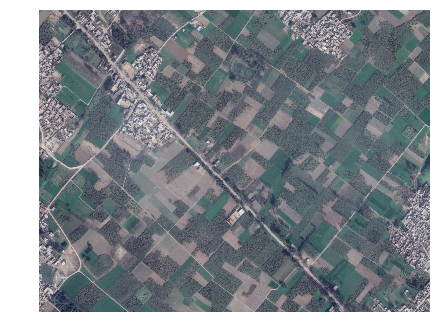

In [28]:
idx = 50

sample = open_image(CITIES[0].ls()[idx])

sample.show(figsize=(7,7))

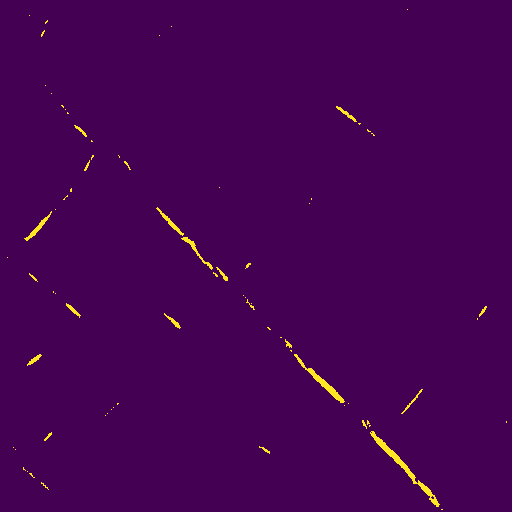

In [29]:
pred = m.predict(sample)
pred[0]

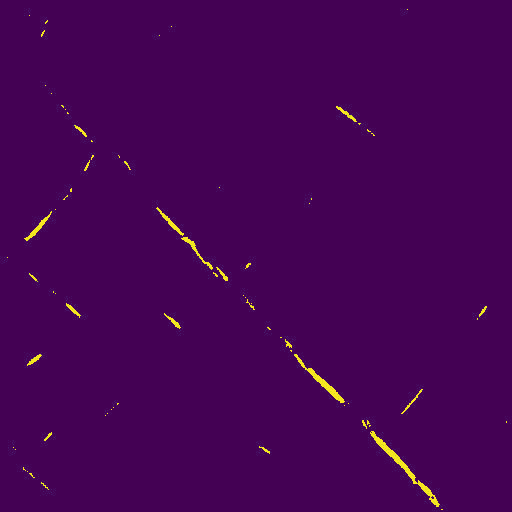

In [36]:
psave = pred[0]
saveat = PRED_OUT.ls()[0]/(CITIES[0].ls()[idx]).name
psave.save(saveat)
open_mask(saveat)

**Fine, this works**

### Making predictions for each city

In [41]:
def predict_and_save(f, dest, model=m):
    """
    Opens images pointed to by `f`
    Saves prediction in `Dest` folder with the exact same file name of `f`
    """
    pred = model.predict(open_image(f))[0]
    #Zero indexing because `predict` returns a tuple with the first element being the predicted mask
    out = dest/f.name
    pred.save(out)

In [42]:
def predict_from_folder(source, dest, model=m):
    """
    Takes all images in `source` folder (type:pathlib.Path)
    Outputs predictions on all inputs in `dest` folder with the exact same name
    `model` is a fastai model
    """
    for i in tqdm(source.ls()):
        predict_and_save(i, dest, model=m)

In [45]:
for i in tqdm(range(5)):
    predict_from_folder(CITIES[i], PRED_OUT.ls()[i])

### Looking at predictions

In [46]:
preds = ImageItemList.from_folder(PRED_OUT.ls()[3])

In [48]:
ims = SegmentationItemList.from_folder(PRED_OUT.ls()[4])

In [ ]:
ims.label_from_folder()

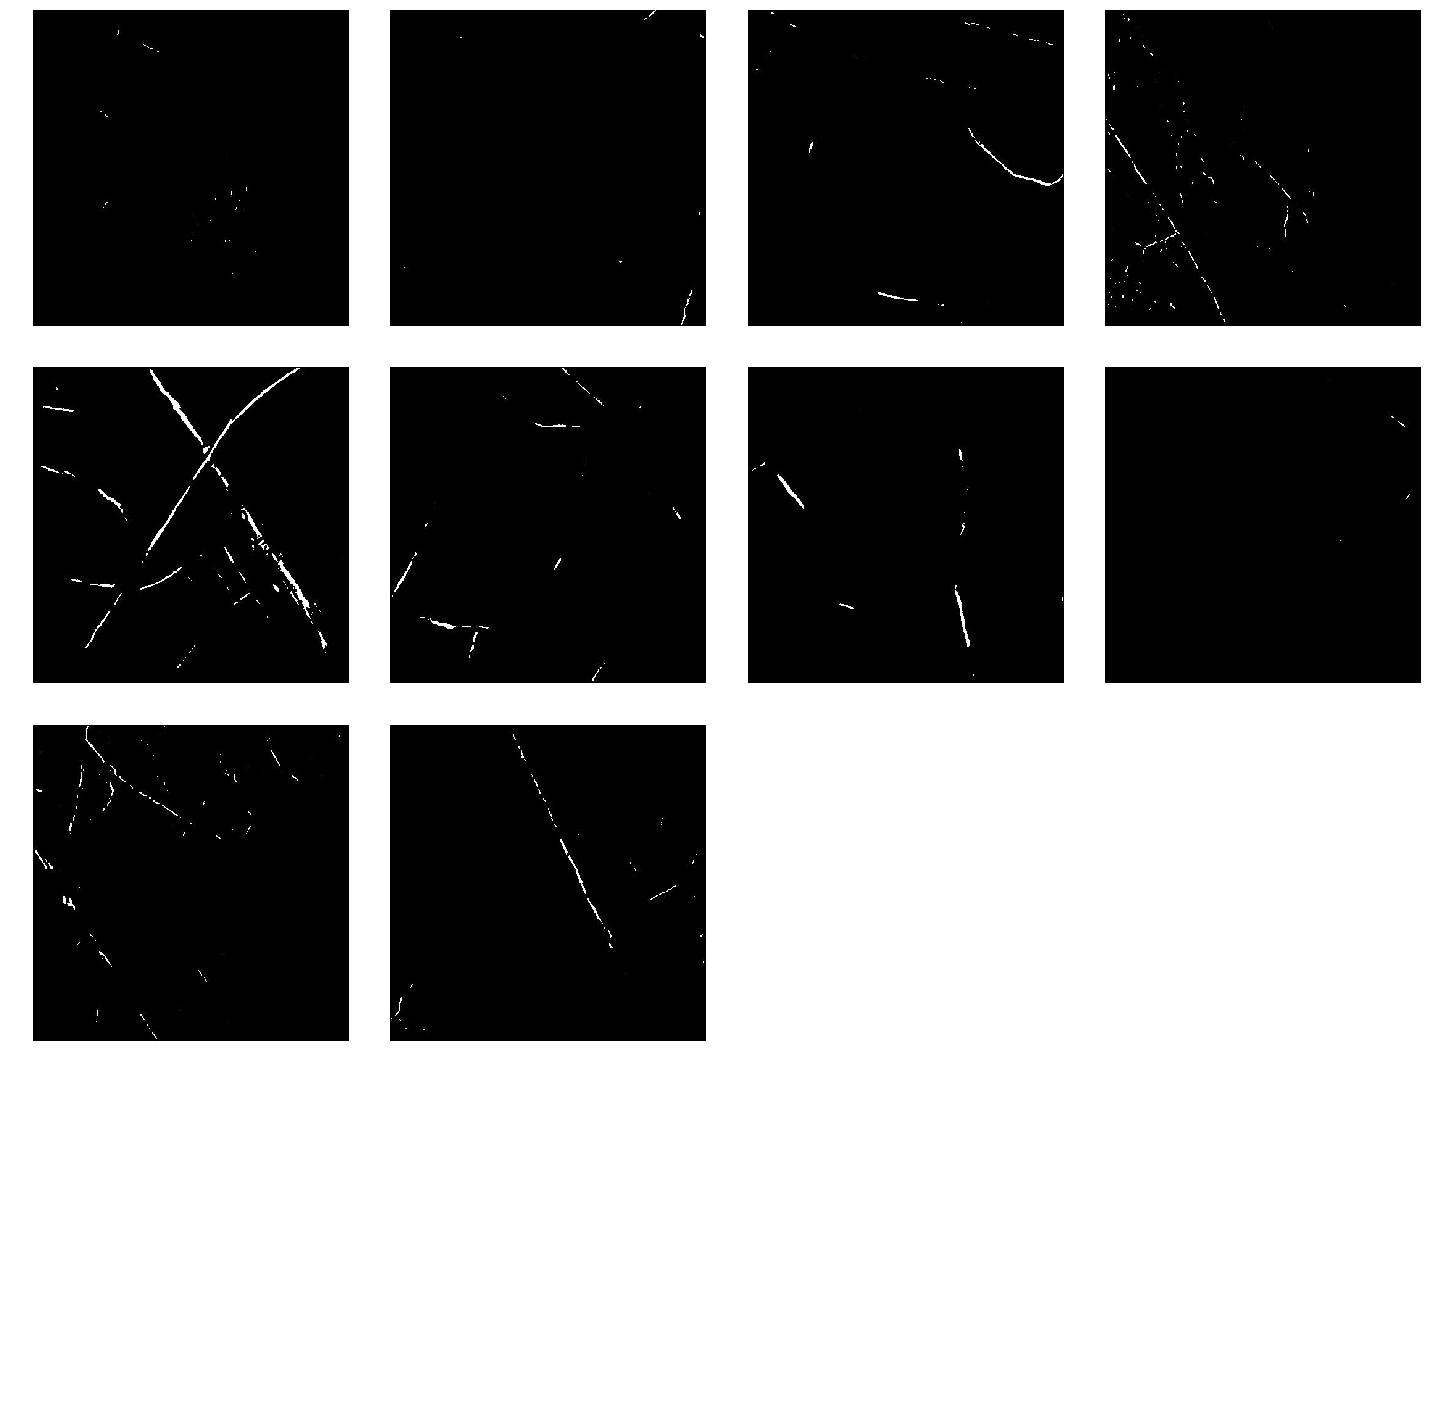

In [47]:
start = 0
end = 10
preds.show_xys(preds[start:end], preds[start:end], figsize=(20,20))

In [50]:
PATH, DATA, PRED_OUT

(PosixPath('/home/akash/Roads/mmi_dataset/dataset_2'),
 PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/5_UP_Cities_JPG'),
 PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/Predictions'))

In [51]:
DATA.ls(), PRED_OUT.ls()

([PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/5_UP_Cities_JPG/Bijnor_UP'),
  PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/5_UP_Cities_JPG/Azamgarh_UP'),
  PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/5_UP_Cities_JPG/Rae Bareilly_UP'),
  PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/5_UP_Cities_JPG/Hardoi_UP'),
  PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/5_UP_Cities_JPG/Mirzapur_UP')],
 [PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/Predictions/Bijnor_UP'),
  PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/Predictions/Azamgarh_UP'),
  PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/Predictions/Rae Bareilly_UP'),
  PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/Predictions/Hardoi_UP'),
  PosixPath('/home/akash/Roads/mmi_dataset/dataset_2/Predictions/Mirzapur_UP')])

In [90]:
def city_to_fnames(CITY):
    """
    Returns names of all files with city names prefixed
    """
    fnames = CITY.ls()
    return [CITY.name + '/' + f.name for f in fnames]

#collecting all files
files = []
for city in DATA.ls():
    files = files + city_to_fnames(city)

# putting images + corresponding labels into a dataframe
images = ['5_UP_Cities_JPG/' + o for o in files]
masks = [str(PRED_OUT) + '/' + o for o in files]

df = pd.DataFrame({'images':images, 'masks':masks})

df.iloc[2]

images                     5_UP_Cities_JPG/Bijnor_UP/42.jpg
masks     /home/akash/Roads/mmi_dataset/dataset_2/Predic...
Name: 2, dtype: object

In [91]:
df.iloc[2][1]

'/home/akash/Roads/mmi_dataset/dataset_2/Predictions/Bijnor_UP/42.jpg'

In [94]:
bs = 8
mass_space_preds = (SegmentationItemList.from_df(df, PATH, 'images')
       .random_split_by_pct(0.1)
       .label_from_df('masks', classes=['Background','Roads'])
       .databunch(bs=bs))

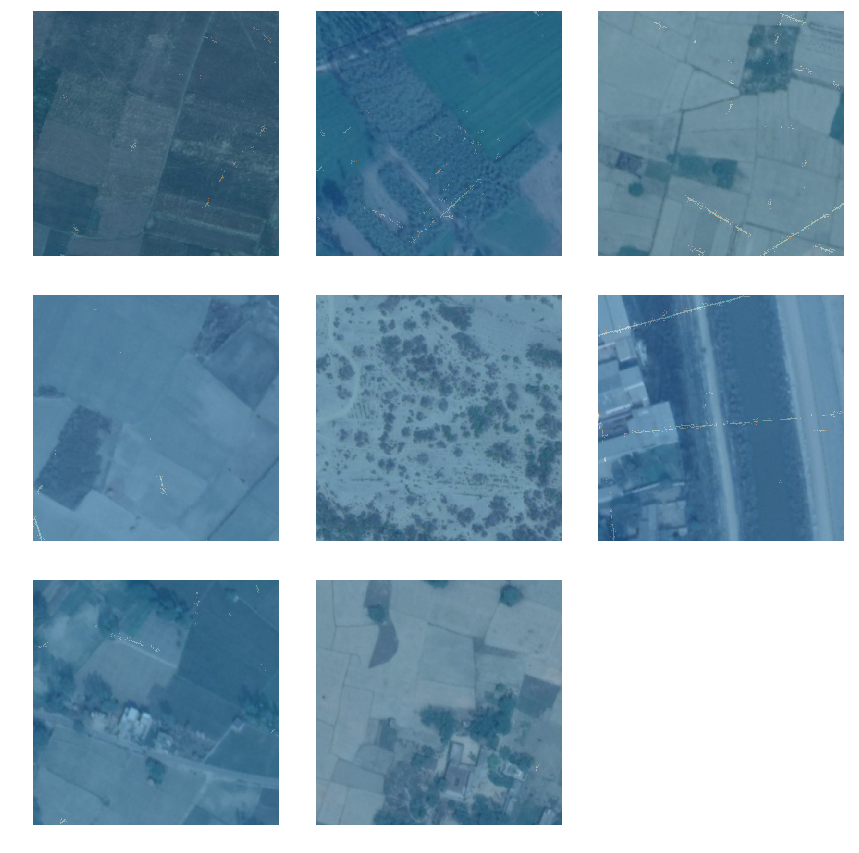

In [96]:
mass_space_preds.show_batch()